# Entities

This section introduces the different entities that can be created and stored in the `geoh5` file format.

![entities](./images/entities.png)

## Groups

`Groups` are effectively containers for other entities, such as ``Objects`` (Points, Curve, Surface, etc.) and other `Groups`. Groups are used to establish `parent-child` relationships and to store information about a collection of entities.  

### RootGroup
By default, the parent of any new `Entity` is the workspace ``RootGroup``.  It is the only entity in the ``Workspace`` without a parent. Users rarely have to interect with the ``Root`` group as it is mainly used to maintain the overall project hierarchy.

![Root](./images/root.png)

### ContainerGroup


A ``ContainerGroup`` can easily be added to the workspace and can be assigned a `name` and `description`.

In [6]:
from geoh5py.groups import ContainerGroup
from geoh5py.workspace import Workspace
import numpy as np

# Create a blank project
workspace = Workspace("my_project.geoh5")

# Add a group
group = ContainerGroup.create(workspace, name='myGroup')

At creation, `"myGroup"` is written to the project ``geoh5`` file and visible in the Analyst project tree.

![Groups](./images/groups.png)

Any entity can be accessed by its `name` or `uid` (unique identifier):

In [2]:
print(group.uid)
print(workspace.get_entity("myGroup")[0] == workspace.get_entity(group.uid)[0])

fd5d7ddd-44b7-4a9f-a2e8-0fc170d03535
False


## Objects

The `geoh5` format enables storing a wide variety of ``Object`` entities that can be displayed in 3D. 
This section describes the collection of ``Objects`` entities currently supported by `geoh5py`.

![Gobjects](./images/objects.png)

### Points

The ``Points`` object consists of a list of `vertices` that define the location of actual data in 3D space. As for all other `Objects`, it can be created from an array of 3D coordinates and added to any group as follow:

In [ ]:
from geoh5py.objects import Points

# Create a blank project
workspace = Workspace("my_project.geoh5")

# Generate a numpy array of xyz locations
n = 100
radius, theta = np.arange(n), np.linspace(0, np.pi*8, n)

x, y = radius * np.cos(theta), radius * np.sin(theta)
z = (x**2. + y**2.)**0.5
xyz = np.c_[x.ravel(), y.ravel(), z.ravel()] # Form a 2D array

# Create the Point object
points = Points.create(
    workspace,       # The target Workspace
    vertices=xyz     # Set vertices
)

![points](./images/points.png){width="50%"}

### Curve

The ``Curve`` object, also known as a polyline, is often used to define contours, survey lines or geological contacts. It is a sub-class of the ``Points`` object with the added `cells` property, that defines the line segments connecting its `vertices`. By default, all vertices are connected sequentially following the order of the input `vertices`.

In [ ]:
from geoh5py.objects import Curve

# Create the Curve object
curve = Curve.create(
    workspace,       # The target Workspace
    vertices=xyz
)

Alternatively, the `cells` property can be modified, either directly or by assigning `parts` identification to each `vertices`:

In [ ]:
# Split the curve into two parts
part_id = np.ones(n, dtype="int32")
part_id[:75] = 2

# Assign the part
curve.parts = part_id
workspace.finalize()

![line](./images/line.png){width="50%"}

### Drillhole


``Drillhole`` objects are different from other objects as their 3D geometry is defined by the `collar` and `surveys` attributes. The `vertices` and `cells` properties are only instantiated when [interval or point log data](#Well-Data) are added. 

In [ ]:
from geoh5py.objects import Drillhole

# Create a simple well
total_depth = 100
dist = np.linspace(0, total_depth, 10)
azm = np.ones_like(dist) * 45.
dip = np.linspace(-89, -75, dist.shape[0])
collar = np.r_[0., 10., 10]

well = Drillhole.create(
    workspace, collar=collar, surveys=np.c_[dist, dip, azm]
)

print(well.name)

![drillhole](./images/drillhole.png){width="50%"}

### Surface


The ``Surface`` object is also described by `vertices` and `cells` that form a net of triangles. If omitted on creation, the `cells` property is calculated using a 2D `scipy.spatial.Delaunay` triangulation.

In [ ]:
from geoh5py.objects import Surface
from scipy.spatial import Delaunay

# Create a triangulated surface from points
surf_2D = Delaunay(xyz[:, :2])

# Create the Surface object
surface = Surface.create(
    workspace, 
    vertices=points.vertices, # Add vertices
    cells=surf_2D.simplices
)

![surface](./images/surface.png){width="50%"}

## GeoImage

The `GeoImage` object handles raster data, either single or 3-band images. 

In [7]:
from geoh5py.objects import GeoImage

geoimage = GeoImage.create(workspace)

Image values can be assigned to the object from either a 2D `numpy.ndarray` for single band (gray):

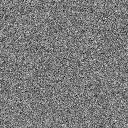

In [3]:
geoimage.image = np.random.randn(128, 128)
display(geoimage.image)

or as 3D `numpy.ndarray` for 3-band RGB image:

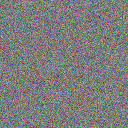

In [4]:
geoimage.image = np.random.randn(128, 128, 3)
display(geoimage.image)

or directly from file (png, jpeg, tiff).

In [24]:
geoimage.image = "./images/flin_flin_geology.jpg"

A `PIL.Image` object gets exposed to the user, which can be used for common raster manipulation (rotation, filtering, etc). The modified raster is stored back on file as a blob (`bytes`).

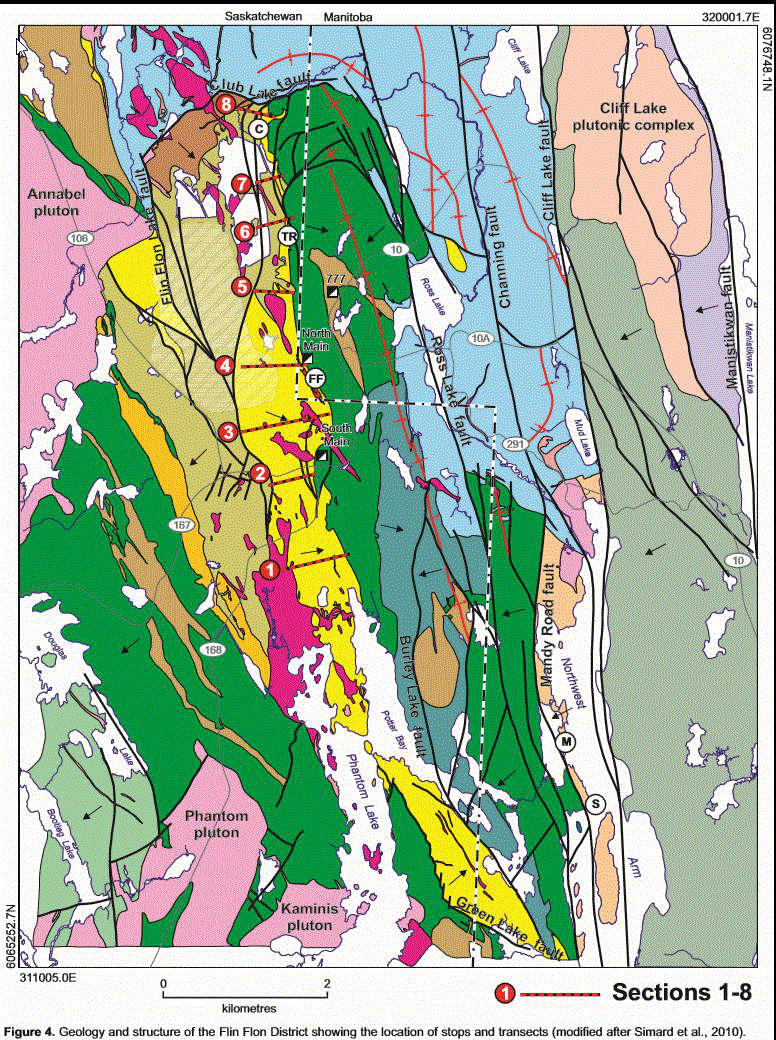

In [29]:
display(geoimage.image)

### Geo-referencing

By default, the `GeoImage` object will be displayed at the origin (xy-plane) with dimensions equal to the pixel count. The utility function [GeoImage.georeference](../api/geoh5py.objects.geoimage.rst#geoh5py.objects.geoimage.georeference) lets users geo-reference the image in 3D space based on at least three (3) input reference points (pixels) with associated world coordinates.

In [9]:
pixels = [
    [18, 73],
    [757, 1014],
    [18, 1014],

]
coords = [
    [311005, 6065252, 0],
    [320001, 6076748, 0],
    [311005, 6076748, 0]
]

geoimage.georeference(pixels, coords) 
print(geoimage.vertices)

[[ 310785.88227334 6077065.63655685       0.        ]
 [ 320232.29093369 6077065.63655685       0.        ]
 [ 320232.29093369 6064360.17428268       0.        ]
 [ 310785.88227334 6064360.17428268       0.        ]]


### Grid2D


The `Grid2D` object defines a regular grid of `cells` often used to display model sections or to compute data derivatives.
A `Grid2D` can be oriented in 3D space using the `origin`, `rotation` and `dip` parameters.

In [ ]:
from geoh5py.objects import Grid2D

# Create the Surface object
grid = Grid2D.create(
    workspace,
    origin = [25, -75, 50],
    u_cell_size = 2.5,
    v_cell_size = 2.5,
    u_count = 64,
    v_count = 16,
    rotation = 90.0,
    dip = 45.0,
)

![grid2d](./images/grid2d.png){width="50%"}

### BlockModel


The ``BlockModel`` object defines a rectilinear grid of cells, also known as a tensor mesh. The `cells` center position is determined by `cell_delimiters` (offsets) along perpendicular axes (`u`, `v`, `z`) and relative to the `origin`. ``BlockModel`` can be oriented horizontally by controlling the `rotation` parameter. 

In [ ]:
from geoh5py.objects import BlockModel

# Create the Surface object
blockmodel = BlockModel.create(
    workspace,
    origin = [25, -100, 50],
    u_cell_delimiters=np.cumsum(np.ones(16) * 5), # Offsets along u
    v_cell_delimiters=np.cumsum(np.ones(32) * 5), # Offsets along v
    z_cell_delimiters=np.cumsum(np.ones(16) * -2.5),  # Offsets along z (down)
    rotation = 30.0
)

![blockmodel](./images/blockmodel.png){width="50%"}

### Octree


The ``Octree`` object is type of 3D grid that uses a tree structure to define `cells`. Each cell can be subdivided it into eight octants allowing for a more efficient local refinement of the mesh. The ``Octree`` object can also be oriented horizontally by controlling the `rotation` parameter. 

In [ ]:
from geoh5py.objects import Octree

octree = Octree.create(
        workspace,
        origin=[25, -100, 50],
        u_count=16,      # Number of cells in power 2
        v_count=32,      
        w_count=16,
        u_cell_size=5.0, # Base cell size (highest octree level)
        v_cell_size=5.0,
        w_cell_size=2.5, # Offsets along z (down)
        rotation=30,
)

By default, the octree mesh will be refined at the lowest level possible along each axes.

![octree](./images/octree.png){width="50%"}